# Resume Classification DL Project

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Environment Setup

In [2]:
!pip install -q kagglehub pandarallel spacy
!python -m spacy download en_core_web_sm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 106.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 2. Import Libraries

In [3]:
import pandas as pd
import numpy as np

import spacy
from pandarallel import pandarallel

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

import re
import os
import warnings
warnings.filterwarnings('ignore')

pandarallel.initialize(progress_bar=True)

print("All libraries imported successfully!")

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
All libraries imported successfully!


## 3. Data Collection

In [ ]:
import kagglehub

print("Downloading Kaggle datasets...")
resume_dataset_path = kagglehub.dataset_download('gauravduttakiit/resume-dataset')
cvscsv_path = kagglehub.dataset_download('leenardeshmukh/cvscsv')
curriculum_vitae_path = kagglehub.dataset_download('leenardeshmukh/curriculum-vitae')
resume_analysis_path = kagglehub.dataset_download("kalimsattar/resume-analysis-datasets")

print('Kaggle datasets downloaded successfully!')

Using Colab cache for faster access to the 'resume-dataset' dataset.
Using Colab cache for faster access to the 'cvscsv' dataset.
Using Colab cache for faster access to the 'curriculum-vitae' dataset.
Using Colab cache for faster access to the 'resume-analysis-datasets' dataset.
Kaggle datasets downloaded successfully!


### 3.1 Load Individual DataFrames

In [ ]:
df1 = pd.read_csv(f'{resume_dataset_path}/UpdatedResumeDataSet.csv')
df2 = pd.read_csv(f'{cvscsv_path}/cvs.csv')
df3 = pd.read_csv(f'{curriculum_vitae_path}/Curriculum Vitae.csv')
df4 = pd.read_csv(f'{cvscsv_path}/cvs.csv')

df5 = pd.read_csv(f'{resume_analysis_path}/Jillani SofTech Updated Resume Dataset.csv')
df6 = pd.read_csv(f'{resume_analysis_path}/Jithin Jagadeesh gpt_dataset.csv')
df7 = pd.read_csv(f'{resume_analysis_path}/Noor Saeed clean_resume_data.csv')
df8 = pd.read_csv(f'{resume_analysis_path}/Snehaan Bhawal Resume Dataset.csv')
df9 = pd.read_csv(f'{resume_analysis_path}/Wahib Mzali Resume data.csv')

print(f"Loaded {len([df1, df2, df3, df4, df5, df6, df7, df8, df9])} datasets from Kaggle")

Loaded 9 datasets from Kaggle


### 3.2 Load HuggingFace Datasets

In [ ]:
df10 = pd.read_csv("hf://datasets/AzharAli05/Resume-Screening-Dataset/dataset.csv")
df10 = df10.drop(['Decision', 'Reason_for_decision', 'Job_Description'], axis=1)

df11 = pd.read_csv("hf://datasets/ahmedheakl/resume-atlas/train.csv")

df12 = pd.read_csv("hf://datasets/0xnbk/resume-domain-classifier-v1-en/validation.csv")
df12 = df12.drop(['label', 'pair_type', 'job_domain'], axis=1)

print(f"Loaded 3 datasets from HuggingFace")

Loaded 3 datasets from HuggingFace


### 3.3 Standardize Column Names

In [ ]:
df7 = df7.drop('ID', axis=1, errors='ignore')
df7 = df7.rename(columns={'Feature': 'Resume'}, errors='ignore')

df8 = df8.drop(['ID', 'Resume_html'], axis=1, errors='ignore')
df8 = df8.rename(columns={'Resume_str': 'Resume'}, errors='ignore')

df9 = df9.rename(columns={'Label': 'Category'}, errors='ignore')

df10 = df10.rename(columns={'Role': 'Category'})
df11 = df11.rename(columns={'Text': 'Resume'})
df12 = df12.rename(columns={'text': 'Resume', 'resume_domain': 'Category'})

print("Column names standardized")

Column names standardized


### 3.4 Merge All Datasets

In [ ]:
full_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12], ignore_index=True)

full_df.drop_duplicates(inplace=True)
full_df.dropna(inplace=True)
full_df.reset_index(drop=True, inplace=True)

print(f"Combined dataset shape: {full_df.shape}")
print(f"Unique categories: {full_df['Category'].nunique()}")
print(f"\nFirst few rows:")
display(full_df.head())

Combined dataset shape: (93943, 2)
Unique categories: 680

First few rows:


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


## 4. Exploratory Data Analysis

In [ ]:
print("Dataset Information:")
print(f"Total resumes: {len(full_df)}")
print(f"Unique categories: {full_df['Category'].nunique()}")
print(f"\nColumn types:")
print(full_df.dtypes)

Dataset Information:
Total resumes: 93943
Unique categories: 680

Column types:
Category    object
Resume      object
dtype: object


In [ ]:
print("Top 20 Categories:")
print(full_df['Category'].value_counts().head(20))

Top 20 Categories:
Category
technology                             5477
healthcare                             4324
finance                                3807
sales_marketing                        3365
design                                 3031
legal                                  2966
manufacturing_operations               2521
education                              2498
Project_manager                        2338
Systems_Administrator                  2319
Database_Administrator                 2219
retail_hospitality                     2115
human_resources                        2107
government_nonprofit                   2101
construction_real_estate               2088
Software_Developer                     1983
Web_Developer,Software_Developer       1848
Python_Developer,Software_Developer    1721
Security_Analyst                       1561
Network_Administrator                  1456
Name: count, dtype: int64


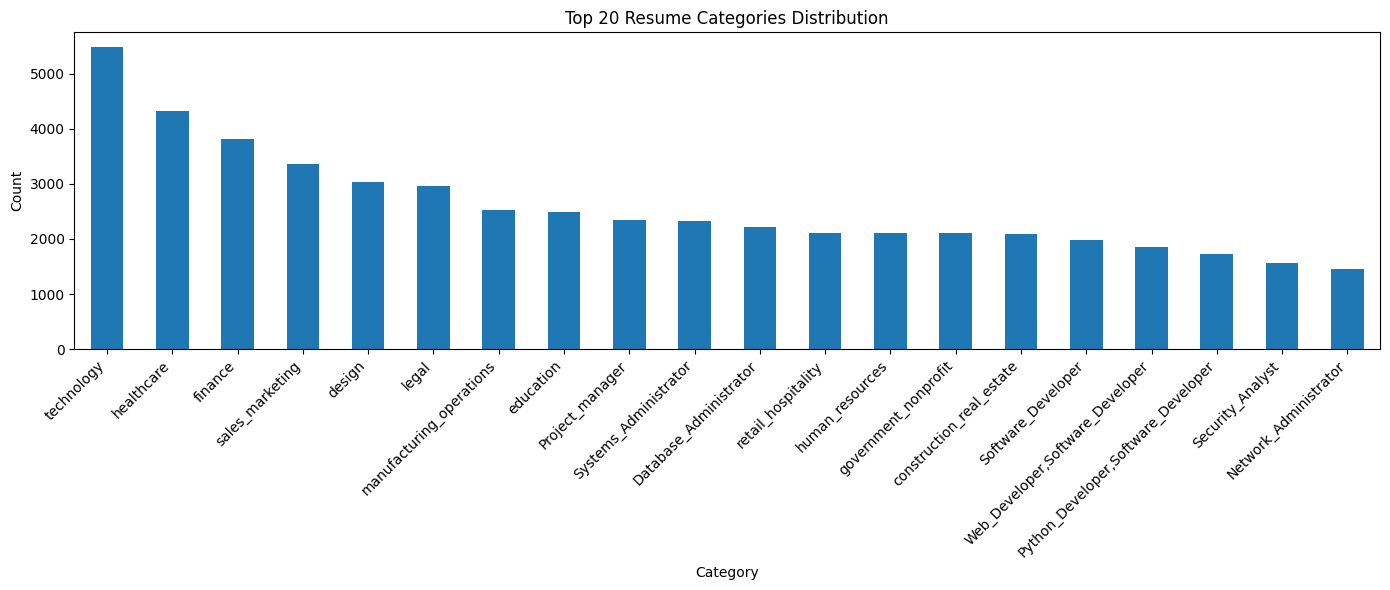

In [ ]:
plt.figure(figsize=(14, 6))
full_df['Category'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Resume Categories Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## load the cleaned data

In [4]:
import zipfile

zip_path = "/content/drive/MyDrive/Resumes-NLP/preprocessed_resumes.zip"

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("/content/extracted")


## 5. Data Preprocessing

### 5.1 Text Cleaning

In [ ]:
def clean_resume_text(text):
  if not isinstance(text, str):
      return ""

  text = re.sub(r'http\S+|www\.\S+', '', text)

  text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text)

  text = re.sub(r'[^a-zA-Z\s]', '', text)

  text = re.sub(r'\s+', ' ', text).strip()

  return text.lower()

In [ ]:
print("Cleaning resume text...")
df['Resume'] = df['Resume'].parallel_apply(clean_resume_text)
print("Text cleaning completed")

display(df.head())

Cleaning resume text...


Text cleaning completed


,Category,Resume
38642,DevOps Engineer,here is a professional resume for matthew nguy...
27070,Software_Developer,embedded developer embedded developer embedded...
36075,E-commerce Specialist,here is a professional resume for zachary fish...
59558,technology,data scientist with years skills pytorch sciki...
26031,"Software_Developer,Web_Developer",senior software engineer fans senior software ...


### 5.2 Initialize spaCy for NLP Processing

In [ ]:
nlp = spacy.load('en_core_web_sm')
print("spaCy model loaded successfully")

spaCy model loaded successfully


### 5.3 Tokenization, Lemmatization and POS with spaCy

In [ ]:
print("Processing text with spaCy (lemmatization & POS tagging)...")

texts = df['Resume'].tolist()
processed_texts = []

docs = nlp.pipe(texts, disable=["parser", "ner"], batch_size=50, n_process=-1)

for doc in tqdm(docs, total=len(texts), desc="Processing Resumes"):
    processed_texts.append(' '.join([
        f"{token.lemma_}_{token.pos_}" for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space
    ]))

df['Resume_POS_text'] = processed_texts

print("\nspaCy processing with POS tags completed.")
display(df[['Resume', 'Resume_POS_text']].head())

Processing text with spaCy (lemmatization & POS tagging)...


Processing Resumes:   0%|          | 0/10000 [00:00<?, ?it/s]


spaCy processing with POS tags completed.


,Resume,Resume_POS_text
38642,here is a professional resume for matthew nguy...,professional_ADJ resume_NOUN matthew_PROPN ngu...
27070,embedded developer embedded developer embedded...,embed_VERB developer_NOUN embed_VERB developer...
36075,here is a professional resume for zachary fish...,professional_ADJ resume_NOUN zachary_PROPN fis...
59558,data scientist with years skills pytorch sciki...,data_NOUN scientist_NOUN year_NOUN skill_NOUN ...
26031,senior software engineer fans senior software ...,senior_ADJ software_NOUN engineer_NOUN fan_NOU...


## 6. Category Normalization

### 6.1 Define Category Normalization Functions

In [ ]:
def normalize_job_titles(df):
    role_variations = {
        'software_developer': ['software engineer', 'software dev', 'programmer',
                              'application developer', 'software engineering', 'technology'],
        'java_developer': ['java engineer', 'java programmer'],
        'python_developer': ['python engineer', 'python programmer'],
        'web_developer': ['web dev', 'website developer'],
        'frontend_developer': ['front end', 'front-end', 'ui developer'],
        'backend_developer': ['back end', 'back-end'],
        'fullstack_developer': ['full stack', 'full-stack'],
        'data_scientist': ['data science'],
        'data_analyst': ['data analysis'],
        'data_engineer': ['data engineering'],
        'network_administrator': ['network admin', 'network engineer'],
        'system_administrator': ['sysadmin', 'systems administrator'],
        'devops_engineer': ['devops', 'dev ops'],
        'project_manager': ['program manager', 'technical project manager'],
        'qa_engineer': ['quality assurance', 'test engineer', 'tester'],
        'mobile_developer': ['android developer', 'ios developer'],
        'database_administrator': ['dba', 'database engineer'],
        'security_engineer': ['cybersecurity', 'information security'],
    }

    title_map = {}
    for base, variations in role_variations.items():
        title_map[base.replace('_', ' ')] = base
        for var in variations:
            title_map[var] = base

    def normalize_category(cat):
        if not isinstance(cat, str):
            return cat

        cat = cat.lower().strip()
        cat = re.sub(r'[_\-/]', ' ', cat)

        if cat in title_map:
            return title_map[cat]

        for key, value in title_map.items():
            if key in cat:
                return value

        return re.sub(r'\s+', '_', re.sub(r'[^a-z0-9\s]', '', cat).strip())

    df['Category'] = df['Category'].parallel_apply(normalize_category)
    return df

def consolidate_multi_labels(df):
    priority_roles = [
        'java_developer', 'python_developer', 'web_developer',
        'frontend_developer', 'backend_developer', 'fullstack_developer',
        'mobile_developer', 'data_scientist', 'data_engineer', 'data_analyst',
        'devops_engineer', 'qa_engineer', 'security_engineer',
        'database_administrator', 'network_administrator', 'system_administrator',
        'project_manager', 'software_developer'
    ]

    def pick_best_label(cat):
        if not isinstance(cat, str) or ',' not in cat:
            return cat

        labels = [l.strip() for l in cat.split(',')]

        for priority_role in priority_roles:
            if priority_role in labels:
                return priority_role

        return labels[0]

    df['Category'] = df['Category'].parallel_apply(pick_best_label)
    return df

def clean_categories(df, min_samples=10):
    print("\nCategory Distribution (Before Cleaning):")
    print(df['Category'].value_counts().head(20))

    counts = df['Category'].value_counts()
    valid = counts[counts >= min_samples].index
    df_filtered = df[df['Category'].isin(valid)]

    removed = len(df) - len(df_filtered)
    print(f"\nRemoved {removed} samples with rare categories")
    print(f"Final shape: {df_filtered.shape}")
    print(f"Unique categories: {df_filtered['Category'].nunique()}")

    return df_filtered

print("Category normalization functions defined")

Category normalization functions defined


### 6.2 Apply Category Normalization

In [ ]:
print("Normalizing categories...")
df = normalize_job_titles(df)
df = consolidate_multi_labels(df)
df = clean_categories(df, min_samples=10)

print("\nCategory normalization completed")
display(df['Category'].value_counts().head(20))

Normalizing categories...



Category Distribution (Before Cleaning):
Category
software_developer          2258
healthcare                   474
finance                      438
network_administrator        390
system_administrator         379
sales_marketing              374
legal                        328
design                       326
education                    321
project_manager              292
database_administrator       273
human_resources              260
manufacturing_operations     258
construction_real_estate     234
retail_hospitality           228
government_nonprofit         220
security_analyst             167
media_entertainment          145
data_scientist               139
product_manager               90
Name: count, dtype: int64

Removed 22 samples with rare categories
Final shape: (9978, 3)
Unique categories: 87

Category normalization completed


,count
Category,
software_developer,2258
healthcare,474
finance,438
network_administrator,390
system_administrator,379
sales_marketing,374
legal,328
design,326
education,321


## 7. Saving Preprocessed Data

In [ ]:
df.to_csv('preprocessed_resumes.csv', index=False)

print("Preprocessed data saved to preprocessed_resumes.csv")

In [5]:
import pandas as pd

df = pd.read_csv("/content/extracted/preprocessed_resumes.csv")

## 8. Feature Extraction

### 8.1 TF-IDF Vectorization

In [6]:
vectorizer = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.8)

df['Resume_POS_text'] = df['Resume_POS_text'].fillna('')
X = vectorizer.fit_transform(df['Resume_POS_text'])
y = df['Category']

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features (vocabulary size): {len(vectorizer.get_feature_names_out())}")
print(f"Example features: {vectorizer.get_feature_names_out()[:20]}")

Feature matrix shape: (93936, 5000)
Number of features (vocabulary size): 5000
Example features: ['aa_noun' 'aaa_noun' 'ab_noun' 'ab_propn' 'abc_propn' 'ability_noun'
 'able_adj' 'absence_noun' 'abstract_adj' 'abuse_noun' 'academic_adj'
 'academy_noun' 'academy_propn' 'accelerate_verb' 'accenture_noun'
 'accept_verb' 'acceptable_adj' 'acceptance_noun' 'acceptance_propn'
 'access_noun']


## 9. Model Preparation

### 9.1 Import Modeling Libraries

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

print("Modeling libraries imported successfully!")

Modeling libraries imported successfully!


### 9.2 Encode Labels and Split Data

In [8]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

y_categorical = to_categorical(y_encoded)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical,
    test_size=0.2,
    random_state=42,
    stratify=y_categorical
)

print(f"Data split into training and testing sets.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Number of categories: {y_categorical.shape[1]}")

Data split into training and testing sets.
X_train shape: (75148, 5000)
X_test shape: (18788, 5000)
Number of categories: 96


## 10. Build the Deep Learning Model

In [10]:
num_features = X_train.shape[1]
num_classes = y_train.shape[1]

model = Sequential()

model.add(Dense(512, input_shape=(num_features,), activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     2,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │        24,672 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,716,512 (10.36 MB)

 Trainable params: 2,716,512 (10.36 MB)

 Non-trainable params: 0 (0.00 B)

## 11. Train the Model

### 11.1 Fit the Model to the Training Data

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

print("Starting model training...")

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

print("Model training completed!")

Starting model training...
Epoch 1/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 66s 55ms/step - accuracy: 0.6090 - loss: 1.7072 - val_accuracy: 0.8726 - val_loss: 0.4394
Epoch 2/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 85s 58ms/step - accuracy: 0.8785 - loss: 0.4271 - val_accuracy: 0.8944 - val_loss: 0.3563
Epoch 3/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 63s 54ms/step - accuracy: 0.9158 - loss: 0.2879 - val_accuracy: 0.9049 - val_loss: 0.3289
Epoch 4/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 61s 52ms/step - accuracy: 0.9352 - loss: 0.2132 - val_accuracy: 0.9070 - val_loss: 0.3228
Epoch 5/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 63s 54ms/step - accuracy: 0.9508 - loss: 0.1610 - val_accuracy: 0.9075 - val_loss: 0.3321
Epoch 6/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 80s 52ms/step - accuracy: 0.9620 - loss: 0.1251 - val_accuracy: 0.9090 - val_loss: 0.3511
Model training completed!


## 12. Evaluate the Model

### 12.1 Calculate Final Loss and Accuracy

In [12]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

Test Accuracy: 90.70%
Test Loss: 0.3228


### 12.2 Confusion Matrix

588/588 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
Classification Report:
                                  precision    recall  f1-score   support

                      accountant       0.77      0.96      0.86       115
                        advocate       0.87      0.85      0.86       107
                     agriculture       0.77      0.70      0.74        71
                     ai_engineer       1.00      1.00      1.00         3
                   ai_researcher       1.00      1.00      1.00        45
                         apparel       0.84      0.85      0.84       102
                 ar_vr_developer       1.00      1.00      1.00        47
                    architecture       0.66      0.69      0.67        61
                            arts       0.84      0.68      0.75        93
              automation_testing       1.00      0.33      0.50         3
                      automobile       0.61      0.68      0.65        75
                        aviation       0.95   

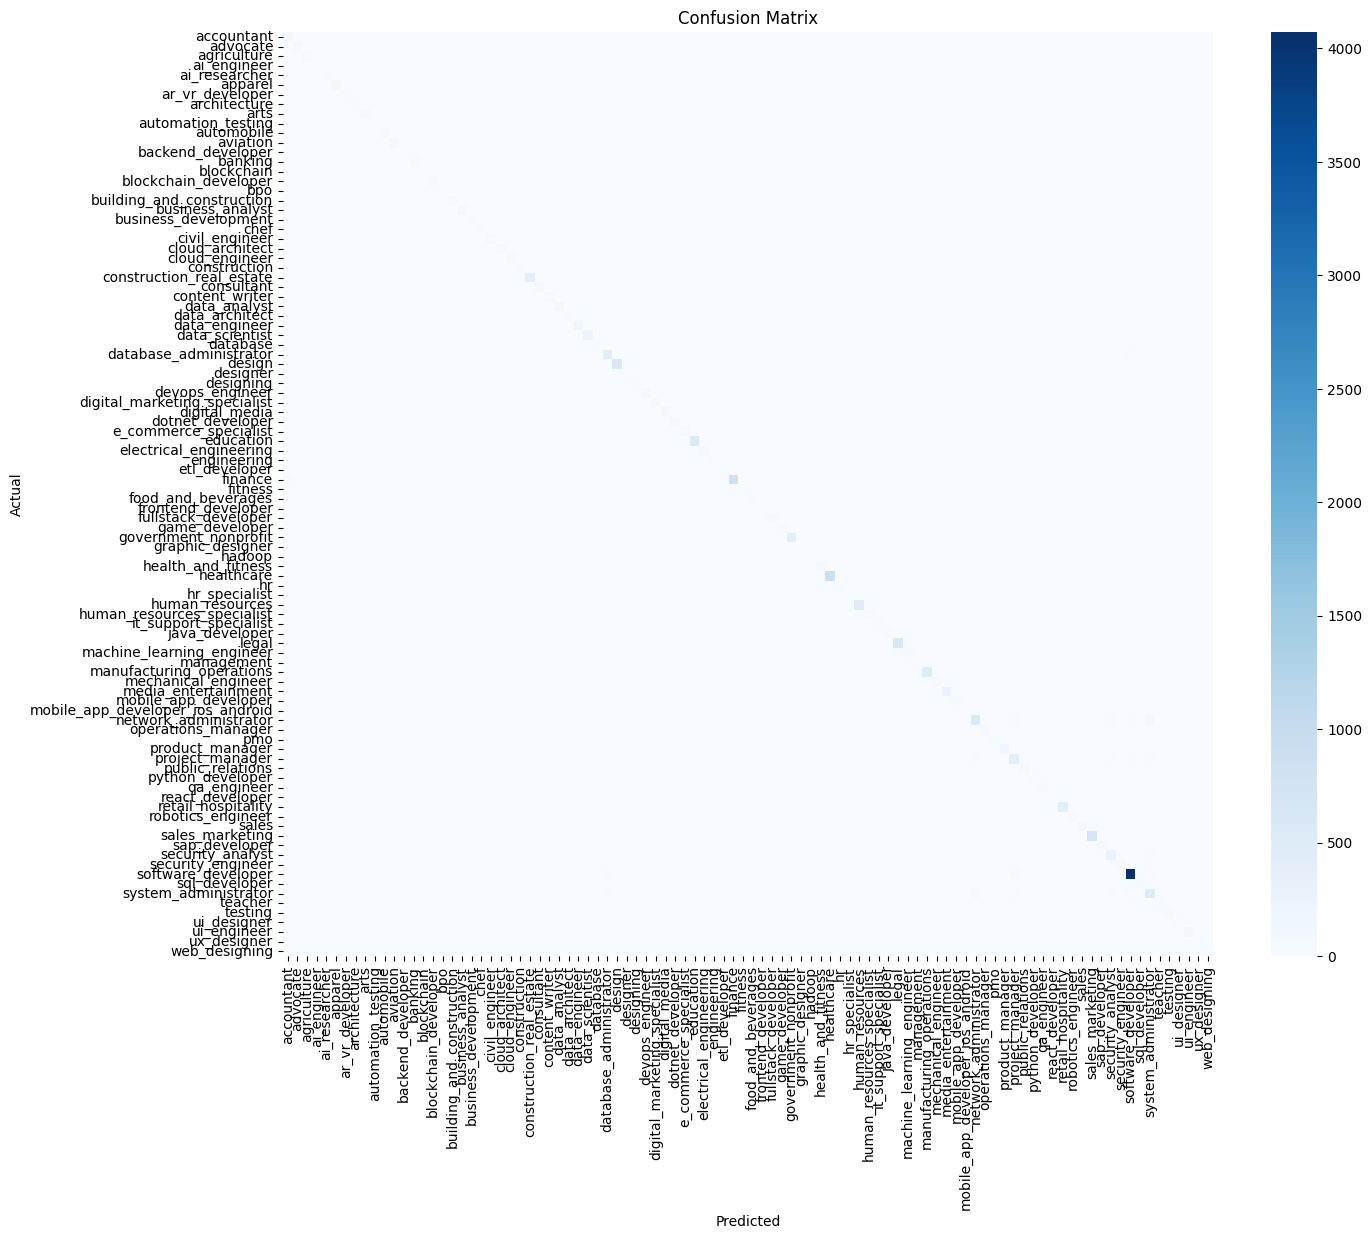

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 12.3 Visualize Training History

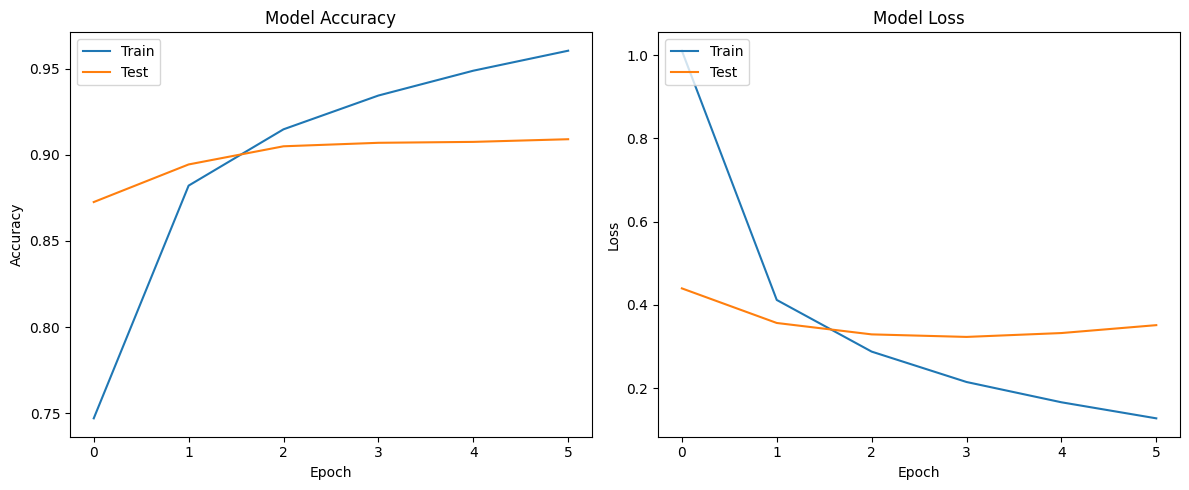

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

### 13. Save the results

In [15]:
import pickle

model.save('resume_classifier_DL_model.keras')
print("DL Model saved to resume_classifier_DL_model.keras")

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
print("TF-IDF Vectorizer saved to tfidf_vectorizer.pkl")

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)
print("Label Encoder saved to label_encoder.pkl")

print("\nAll model components saved successfully")

DL Model saved to resume_classifier_DL_model.keras
TF-IDF Vectorizer saved to tfidf_vectorizer.pkl
Label Encoder saved to label_encoder.pkl

All model components saved successfully
